## 분석서버 구현
- 웹서버에서 보내주는 프레임을 분석, 결과를 results에 쌓아 웹서버에 보내줌


- name: 남기범
- project: 야구 AI 캐스터
- stack: 작성 예정

### 환경 설정

In [ ]:
# 필요 라이브러리 설치
!pip install python-multipart
!pip install pyngrok
!pip install fastapi uvicorn
!pip install opencv-python-headless
!pip install requests
!pip install numpy

# # 텐서플로우 버전 변경
# !pip install tensorflow==2.15.0 --no-cache-dir
!pip install tensorflow==2.11.0
!pip install protobuf==3.20.3

In [ ]:
# Pitchbox_detection 모델 다운로드
!gdown https://drive.google.com/uc?id=1JIqA4rOqxf3bIXlMUhgLarkUy4-8dQEs -O best_model_dataset_5_test_1.0.h5

## FastAPI, uvicorn 기반 서버 구현과 javascript 코드들

### 코드 업데이트 (24.08.08)
- 분석서버 구현

In [ ]:
import os
from fastapi import FastAPI, UploadFile, Form, HTTPException
from fastapi.responses import JSONResponse
import numpy as np
from io import BytesIO
import tensorflow as tf
import cv2
from starlette.middleware.cors import CORSMiddleware

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

model_path = '/content/best_model_dataset_5_test_1.0.h5'
model = tf.keras.models.load_model(model_path)

@app.post("/analyze")
async def analyze_frame(frame: UploadFile, frame_number: int = Form(...), timestamp: str = Form(...)):
    try:
        contents = await frame.read()
        np_array = np.frombuffer(contents, np.uint8)
        img = cv2.imdecode(np_array, cv2.IMREAD_COLOR)

        resized_frame = cv2.resize(img, (224, 224))
        input_tensor = np.expand_dims(resized_frame, axis=0) / 255.0

        prediction = model.predict(input_tensor, verbose=0)

        if prediction[0] > 0.95:
            result = 1
        else:
            result = 0

        return JSONResponse({"frame_number": frame_number, "timestamp": timestamp, "result": result})
    except Exception as e:
        print(f"Error in analyze_frame: {e}")
        raise HTTPException(status_code=500, detail=f"Error analyzing frame: {e}")

## ngrok 접근 및 서버 실행
https://ngrok.com/

auth_token = " " 부분에 각자의 ngrok API token을 넣어 활용

In [ ]:
# ngrok 접근 및 서버 실행
import nest_asyncio
from pyngrok import ngrok
import uvicorn
# auth_token = "2hEs3B2AsTNULltFaSrhdRm7oCm_71m1exj3dmrWJAzafZcdF"
# auth_token = "2jGjA04BIOeiMkIHY9UNZWQeOQA_254RPRM5srqPrzuvVVK2o"
auth_token = "2kMVZJ88nkGSVP6wyW6SHomTkYn_4mwkHuVYceHcTq58SvZ3H"
ngrok.set_auth_token(auth_token)
ngrokTunnel = ngrok.connect(8000)
print("공용 URL", ngrokTunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

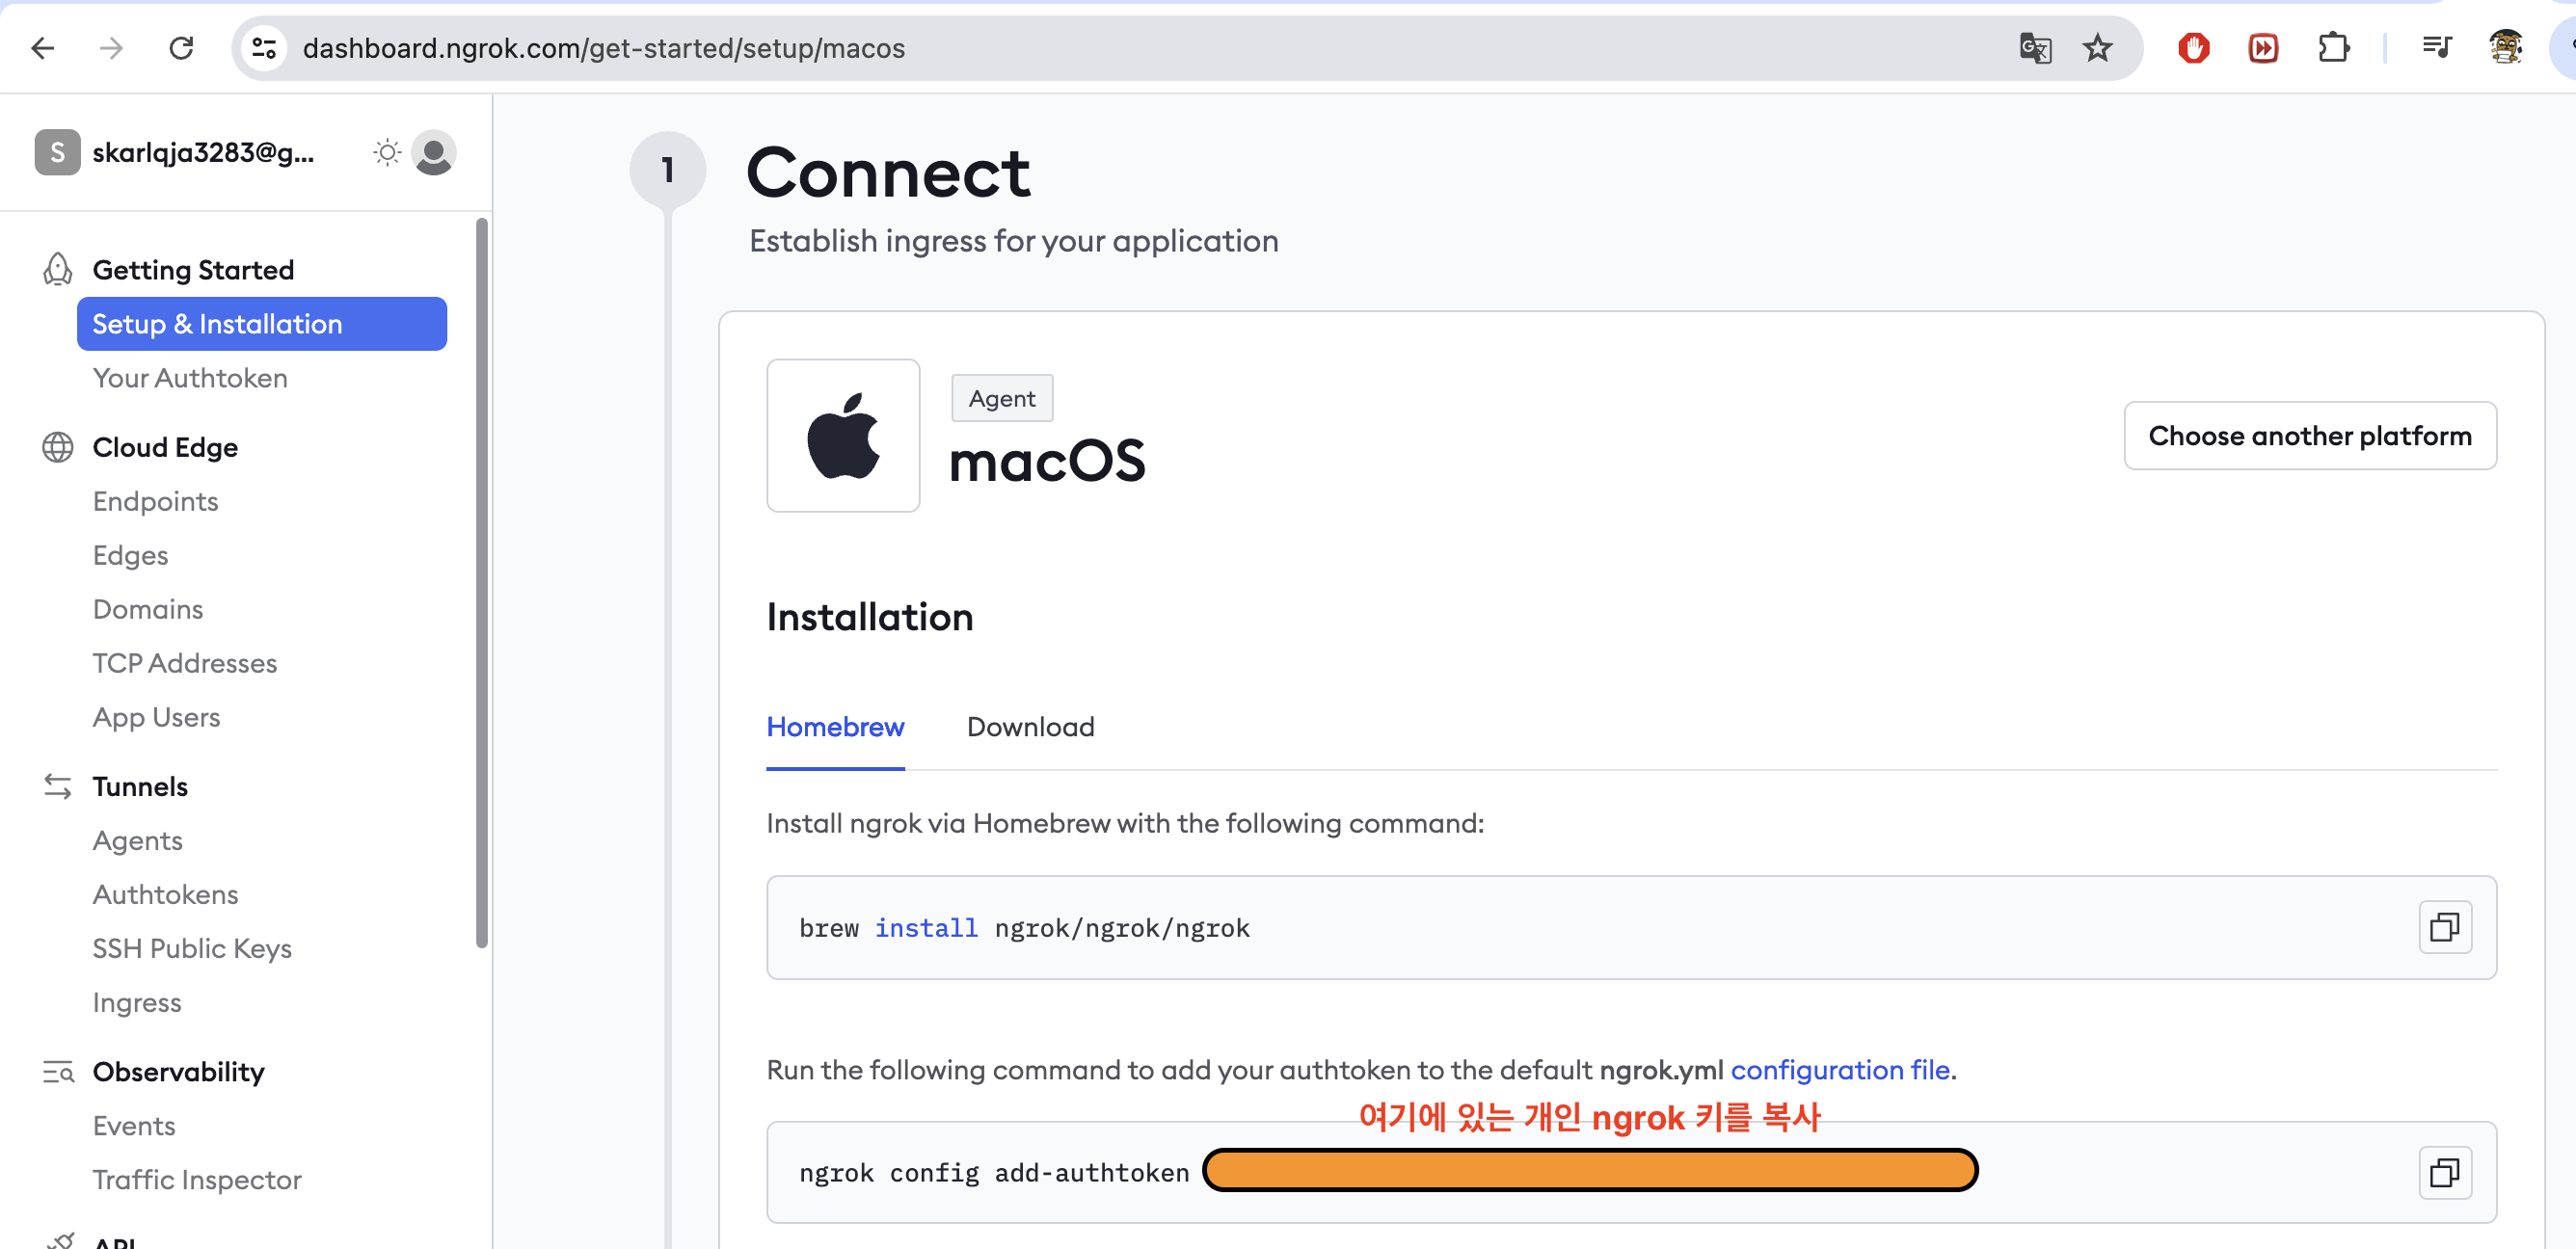